In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install neuraloperator torch the_well numpy scienceplots

In [ ]:
import os
import logging
import argparse
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict

from tqdm import tqdm
from einops import rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from the_well.data import WellDataset
from the_well.benchmark.models.unet_convnext import UNetConvNext

In [ ]:
device = 'cuda'
base_path = '/content/drive/MyDrive/yt/datasets'

In [ ]:
class CNextUNetbaseline(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 initial_dimension: int,
                 up_down_blocks: int,
                 blocks_per_stage: int,
                 bottleneck_blocks: int,
                 spatial_resolution: tuple,
                 spatial_dims: int = 2):

         super().__init__()

         self.model = UNetConvNext(
             dim_in=in_channels,
             dim_out=out_channels,
             n_spatial_dims=spatial_dims,
             spatial_resolution=spatial_resolution,
             stages=up_down_blocks,
             blocks_per_stage=blocks_per_stage,
             blocks_at_neck=bottleneck_blocks,
             init_features=initial_dimension
             )

    def forward(self, x):
        return self.model(x)

In [ ]:
class ModelTrainer:
    def __init__(self, path, model, device: str = 'cuda', n_workers: int = None, mu=None, sigma=None):
        self.path = path
        self.model = model

        if device == 'cuda' and torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

        if n_workers is None:
            self.n_workers = 15
        else:
            self.n_workers = int(n_workers)

        self.F = 11
        self.mu = mu
        self.sigma = sigma
        self.model_instance = None

    def _loader(self, split, n_steps_input, n_steps_output):
        return WellDataset(
            well_base_path=self.path,
            well_dataset_name='active_matter',
            well_split_name=split,
            n_steps_input=n_steps_input,
            n_steps_output=n_steps_output,
            use_normalization=False
        )

    def _setup(self, train_dataset, n_input, n_output):
        logging.info('Setting up model and normalisation')

        if self.mu is None or self.sigma == None:
            max_samples = min(30, len(train_dataset))
            sample_idx  = np.linspace(0, len(train_dataset) - 1, num=max_samples).astype(int)

            mu_sum = torch.zeros(self.F, dtype=torch.float32)
            sigma_sum = torch.zeros(self.F, dtype=torch.float32)
            count = 0

            for idx in sample_idx:
                item = train_dataset[idx]
                x = item['input_fields']

                if isinstance(x, np.ndarray):
                    x = torch.from_numpy(x).float()
                else:
                    x = x.float()

                x = x.reshape(-1, self.F)

                mu_sum += x.mean(dim=0)
                sigma_sum += x.std(dim=0)
                count += 1

            self.mu = (mu_sum / count).to(self.device)
            self.sigma = (sigma_sum / count).to(self.device)
            self.sigma[self.sigma == 0.0] = 1.0

            logging.info('Normalisation stats calculated on device %s', str(self.device))

        else:

            if isinstance(self.mu, np.ndarray):
                self.mu = torch.from_numpy(self.mu).float().to(self.device)
            else:
                self.mu = self.mu.to(self.device)
            if isinstance(self.sigma, np.ndarray):
                self.sigma = torch.from_numpy(self.sigma).float().to(self.device)
            else:
                self.sigma = self.sigma.to(self.device)

            logging.info('Using provided mu, sigma')

        in_channels = n_input * self.F
        out_channels = n_output * self.F
        grid = (256, 256)

        self.model_instance = self.model(
            in_channels=in_channels,
            out_channels=out_channels,
            spatial_resolution=grid,
            initial_dimension=42,
            up_down_blocks=4,
            blocks_per_stage=2,
            bottleneck_blocks=1
            ).to(self.device)

        self.model_instance.to(memory_format=torch.channels_last)

    def _preprocess(self, x):
        x = x.to(self.device, non_blocking=True).float()
        return (x - self.mu) / self.sigma

    def _postprocess(self, y):
        n_channels = y.shape[1]
        repeat = n_channels // self.F
        mu_b = self.mu.repeat(repeat).view(1, n_channels, 1, 1)
        sigma_b = self.sigma.repeat(repeat).view(1, n_channels, 1, 1)
        return (y * sigma_b) + mu_b

In [ ]:
class ModelPredictor:
    def __init__(self,
                 checkpoint_path: str,
                 data_path: str,
                 device: str = 'cuda',
                 n_input: int = 4,
                 n_output: int = 1):

        self.device = device if torch.cuda.is_available() and device == 'cuda' else 'cpu'
        self.n_input = n_input
        self.n_output = n_output

        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint not found at: {checkpoint_path}")

        print(f"Loading checkpoint from {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        stats = checkpoint.get('stats', None)
        if stats is None:
          mu_val = checkpoint.get('mu')
          sigma_val = checkpoint.get('sigma')
        else:
          mu_val = stats['mu']
          sigma_val = stats['sigma']

        self.trainer = ModelTrainer(
            path=data_path,
            model=CNextUNetbaseline,
            device=self.device,
            mu=mu_val,
            sigma=sigma_val
        )

        in_channels = n_input * self.trainer.F
        out_channels = n_output * self.trainer.F
        grid = (256, 256)

        self.model = CNextUNetbaseline(
            in_channels=in_channels,
            out_channels=out_channels,
            spatial_resolution=grid,
            initial_dimension=42,
            up_down_blocks=4,
            blocks_per_stage=2,
            bottleneck_blocks=1
        ).to(self.device)

        self.model.to(memory_format=torch.channels_last)

        if 'model' not in checkpoint:
          self.model.load_state_dict(checkpoint['model_state'])
        else:
          self.model.load_state_dict(checkpoint['model'])

        self.model.eval()
        print("Model loaded and ready for inference.")

    def get_dataset(self, split='test'):
        """Helper to get the dataset using the trainer's loader logic."""
        return self.trainer._loader(split, self.n_input, self.n_output)

    def predict(self, sample_idx: int, split: str = 'test'):
        """
        Performs inference on a single sample from the specified split.
        """
        dataset = self.get_dataset(split)

        print(len(dataset))

        if sample_idx >= len(dataset):
            raise IndexError(f'Index {sample_idx} out of bounds for split {split} (size: {len(dataset)})')

        sample = dataset[sample_idx]

        x_raw = sample['input_fields']
        if isinstance(x_raw, np.ndarray):
            x_raw = torch.from_numpy(x_raw)
        x_raw = x_raw.unsqueeze(0)

        x_norm = self.trainer._preprocess(x_raw)

        x_in = rearrange(x_norm, "B T X Y F -> B (T F) X Y")
        x_in = x_in.contiguous(memory_format=torch.channels_last)

        with torch.no_grad():
            with torch.amp.autocast(self.device):
                y_pred_norm = self.model(x_in)

        y_pred = self.trainer._postprocess(y_pred_norm)

        y_pred = rearrange(y_pred, "B (T F) X Y -> B T X Y F", F=self.trainer.F)

        y_true = sample['output_fields']
        if isinstance(y_true, np.ndarray):
            y_true = torch.from_numpy(y_true)
        y_true = y_true.unsqueeze(0) # Add Batch

        return {
            'input': x_raw.cpu().numpy(),
            'true': y_true.cpu().numpy(),
            'prediction': y_pred.cpu().numpy()
        }

## Generating figures

In [ ]:
model_data = torch.load(base_path + '/best_model_epoch15.pth')
print(model_data.keys())

dict_keys(['epoch', 'model_state', 'optimizer_state', 'mu', 'sigma'])


In [ ]:
## baseline
base = ModelPredictor(base_path + '/best_model_epoch15.pth', base_path)

## physics
physics = ModelPredictor(base_path + '/best_model.pth', base_path)

Loading checkpoint from /content/drive/MyDrive/yt/datasets/best_model_epoch15.pth...
Model loaded and ready for inference.
Loading checkpoint from /content/drive/MyDrive/yt/datasets/best_model.pth...
Model loaded and ready for inference.


In [ ]:
base_snap = base.predict(1000, 'valid')

physics_snap = physics.predict(1000, 'valid')

1848
1848


In [ ]:
# baseline data
base_in   = base_snap['input'].squeeze()
base_true = base_snap['true'].squeeze()
base_pred = base_snap['prediction'].squeeze()

In [ ]:
# physics data
physics_in   = physics_snap['input'].squeeze()
physics_true = physics_snap['true'].squeeze()
physics_pred = physics_snap['prediction'].squeeze()

In [ ]:
# velocities (baseline)

base_true_vx = base_true[:, :, 1]
base_true_vy = base_true[:, :, 2]

btrue_dvx_dx, btrue_dvx_dy = np.gradient(base_true_vx)
btrue_dvy_dx, btrue_dvy_dy = np.gradient(base_true_vy)

base_true_div = btrue_dvx_dx + btrue_dvy_dy

base_pred_vx = base_pred[:, :, 1]
base_pred_vy = base_pred[:, :, 2]

bpred_dvx_dx, bpred_dvx_dy = np.gradient(base_pred_vx)
bpred_dvy_dx, bpred_dvy_dy = np.gradient(base_pred_vy)

base_pred_div = bpred_dvx_dx + bpred_dvy_dy

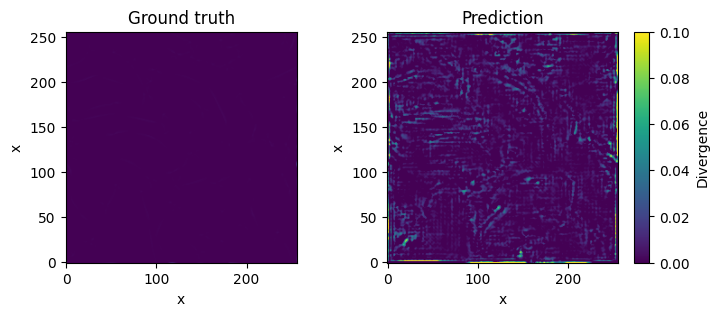

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].imshow(base_true_div, vmin=-2.542045e-05, vmax=0.1)
axs[0].set_title('Ground truth')

cmap = axs[1].imshow(base_pred_div, vmin=-2.542045e-05, vmax=0.1)
axs[1].set_title('Prediction')

for j in range(2):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')
  axs[j].set_ylabel('x')

fig.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label='Divergence', pad=0.02)
plt.show()

/tmp/ipython-input-287371126.py:3: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(np.abs(base_true_div)), vmin=-6.923689898635007, vmax=0)
/tmp/ipython-input-287371126.py:6: RuntimeWarning: divide by zero encountered in log10
  cmap = axs[1].imshow(np.log10(np.abs(base_pred_div)), vmin=-6.923689898635007, vmax=0)


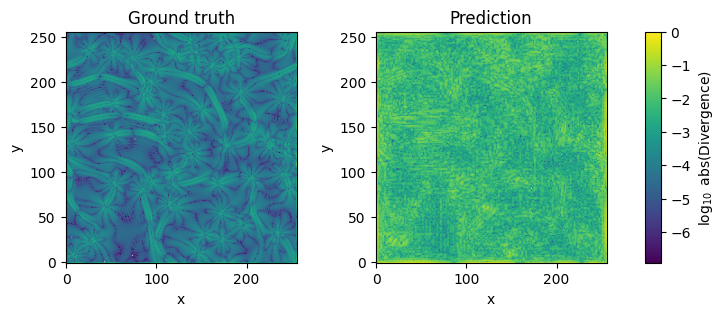

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].imshow(np.log10(np.abs(base_true_div)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Ground truth')

cmap = axs[1].imshow(np.log10(np.abs(base_pred_div)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Prediction')

for j in range(2):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')
  axs[j].set_ylabel('y')

fig.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Divergence)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/div_baseline.pdf', bbox_inches='tight')

In [ ]:
!pwd

/content


In [ ]:
print(np.min(np.log10(np.abs(base_true_div))))
print(np.max(np.log10(np.abs(base_true_div))))

-inf
-1.8395991


/tmp/ipython-input-1573016290.py:1: RuntimeWarning: divide by zero encountered in log10
  print(np.min(np.log10(np.abs(base_true_div))))
/tmp/ipython-input-1573016290.py:2: RuntimeWarning: divide by zero encountered in log10
  print(np.max(np.log10(np.abs(base_true_div))))


In [ ]:
print(np.min(np.log10(np.abs(base_pred_div))))
print(np.max(np.log10(np.abs(base_pred_div))))

-inf
-0.40251023


/tmp/ipython-input-3368495524.py:1: RuntimeWarning: divide by zero encountered in log10
  print(np.min(np.log10(np.abs(base_pred_div))))
/tmp/ipython-input-3368495524.py:2: RuntimeWarning: divide by zero encountered in log10
  print(np.max(np.log10(np.abs(base_pred_div))))


In [ ]:
# velocities (physics)

physics_true_vx = physics_true[:, :, 1]
physics_true_vy = physics_true[:, :, 2]

ptrue_dvx_dx, ptrue_dvx_dy = np.gradient(physics_true_vx)
ptrue_dvy_dx, ptrue_dvy_dy = np.gradient(physics_true_vy)

physics_true_div = ptrue_dvx_dx + ptrue_dvy_dy

physics_pred_vx = physics_pred[:, :, 1]
physics_pred_vy = physics_pred[:, :, 2]

ppred_dvx_dx, ppred_dvx_dy = np.gradient(physics_pred_vx)
ppred_dvy_dx, ppred_dvy_dy = np.gradient(physics_pred_vy)

physics_pred_div = ppred_dvx_dx + ppred_dvy_dy

/tmp/ipython-input-3115567795.py:3: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(np.abs(physics_true_div)), vmin=-6.923689898635007, vmax=0)
/tmp/ipython-input-3115567795.py:6: RuntimeWarning: divide by zero encountered in log10
  cmap = axs[1].imshow(np.log10(np.abs(physics_pred_div)), vmin=-6.923689898635007, vmax=0)


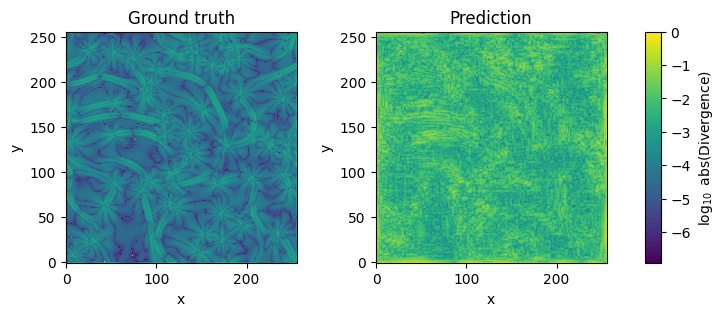

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].imshow(np.log10(np.abs(physics_true_div)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Ground truth')

cmap = axs[1].imshow(np.log10(np.abs(physics_pred_div)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Prediction')

for j in range(2):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')
  axs[j].set_ylabel('y')

fig.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Divergence)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/div_physics.pdf', bbox_inches='tight')

/tmp/ipython-input-3508655075.py:3: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(np.abs(physics_true_div)), vmin=-6.923689898635007, vmax=0)
/tmp/ipython-input-3508655075.py:6: RuntimeWarning: divide by zero encountered in log10
  cmap = axs[1].imshow(np.log10(np.abs(base_pred_div)), vmin=-6.923689898635007, vmax=0)
/tmp/ipython-input-3508655075.py:9: RuntimeWarning: divide by zero encountered in log10
  cmap = axs[2].imshow(np.log10(np.abs(physics_pred_div)), vmin=-6.923689898635007, vmax=0)


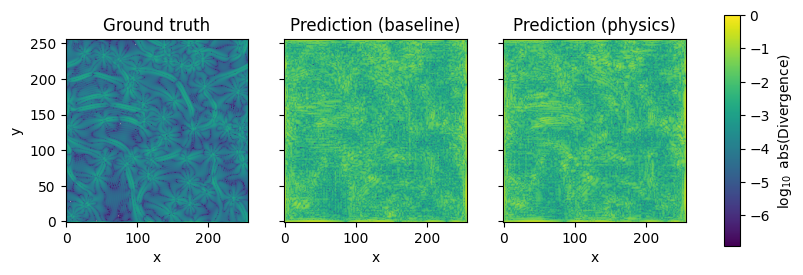

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

axs[0].imshow(np.log10(np.abs(physics_true_div)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Ground truth')

cmap = axs[1].imshow(np.log10(np.abs(base_pred_div)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Prediction (baseline)')

cmap = axs[2].imshow(np.log10(np.abs(physics_pred_div)), vmin=-6.923689898635007, vmax=0)
axs[2].set_title('Prediction (physics)')

for j in range(3):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')

axs[0].set_ylabel('y')

fig.subplots_adjust(wspace=0.2, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Divergence)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/divergence.pdf', bbox_inches='tight')

In [ ]:
# Tensor symmetry

base_true_Dxy = base_true[:, :, 4]
base_true_Dyx = base_true[:, :, 5]
base_true_Exy = base_true[:, :, 8]
base_true_Eyx = base_true[:, :, 9]

btrue_sym_D = base_true_Dxy - base_true_Dyx
btrue_sym_E = base_true_Exy - base_true_Eyx

base_pred_Dxy = base_pred[:, :, 4]
base_pred_Dyx = base_pred[:, :, 5]
base_pred_Exy = base_pred[:, :, 8]
base_pred_Eyx = base_pred[:, :, 9]

bpred_sym_D = base_pred_Dxy - base_pred_Dyx
bpred_sym_E = base_pred_Exy - base_pred_Eyx

physics_true_Dxy = physics_true[:, :, 4]
physics_true_Dyx = physics_true[:, :, 5]
physics_true_Exy = physics_true[:, :, 8]
physics_true_Eyx = physics_true[:, :, 9]

physics_pred_Dxy = physics_pred[:, :, 4]
physics_pred_Dyx = physics_pred[:, :, 5]
physics_pred_Exy = physics_pred[:, :, 8]
physics_pred_Eyx = physics_pred[:, :, 9]

ppred_sym_D = physics_pred_Dxy - physics_pred_Dyx
ppred_sym_E = physics_pred_Exy - physics_pred_Eyx

/tmp/ipython-input-2729962187.py:3: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(np.abs(btrue_sym_D - bpred_sym_D)), vmin=-6.923689898635007, vmax=0)
/tmp/ipython-input-2729962187.py:6: RuntimeWarning: divide by zero encountered in log10
  cmap = axs[1].imshow(np.log10(np.abs(btrue_sym_D - ppred_sym_D)), vmin=-6.923689898635007, vmax=0)


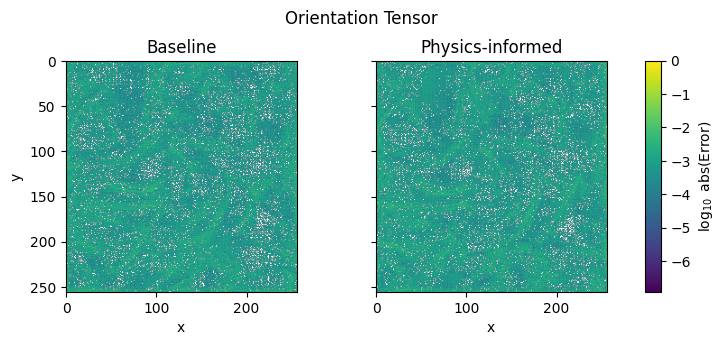

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

axs[0].imshow(np.log10(np.abs(btrue_sym_D - bpred_sym_D)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Baseline')

cmap = axs[1].imshow(np.log10(np.abs(btrue_sym_D - ppred_sym_D)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Physics-informed')

for j in range(2):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')

axs[0].set_ylabel('y')

fig.suptitle('Orientation Tensor', y=1.05)
fig.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Error)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/error_sym_D.pdf', bbox_inches='tight')

/tmp/ipython-input-2581277501.py:6: RuntimeWarning: divide by zero encountered in log10
  cmap = axs[1].imshow(np.log10(np.abs(btrue_sym_D - bpred_sym_D)), vmin=-6.923689898635007, vmax=0)
/tmp/ipython-input-2581277501.py:9: RuntimeWarning: divide by zero encountered in log10
  cmap = axs[2].imshow(np.log10(np.abs(btrue_sym_D - ppred_sym_D)), vmin=-6.923689898635007, vmax=0)


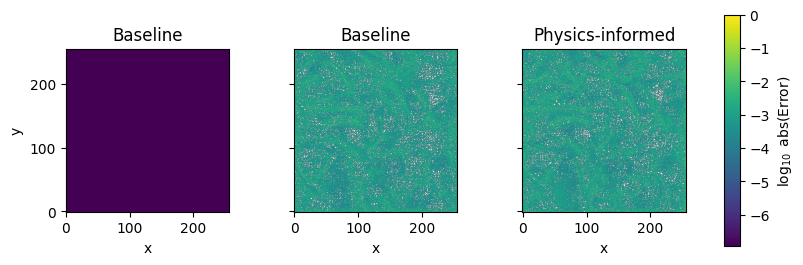

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

axs[0].imshow(btrue_sym_D)
axs[0].set_title('Baseline')

cmap = axs[1].imshow(np.log10(np.abs(btrue_sym_D - bpred_sym_D)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Baseline')

cmap = axs[2].imshow(np.log10(np.abs(btrue_sym_D - ppred_sym_D)), vmin=-6.923689898635007, vmax=0)
axs[2].set_title('Physics-informed')

for j in range(3):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')

axs[0].set_ylabel('y')

fig.subplots_adjust(wspace=0.4, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Error)', pad=0.05)
#plt.savefig('/content/drive/MyDrive/yt/error_sym_D.pdf', bbox_inches='tight')
plt.show()

/tmp/ipython-input-2364573.py:3: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(np.abs(btrue_sym_E - bpred_sym_E)), vmin=-6.923689898635007, vmax=0)
/tmp/ipython-input-2364573.py:6: RuntimeWarning: divide by zero encountered in log10
  cmap = axs[1].imshow(np.log10(np.abs(btrue_sym_E - ppred_sym_E)), vmin=-6.923689898635007, vmax=0)


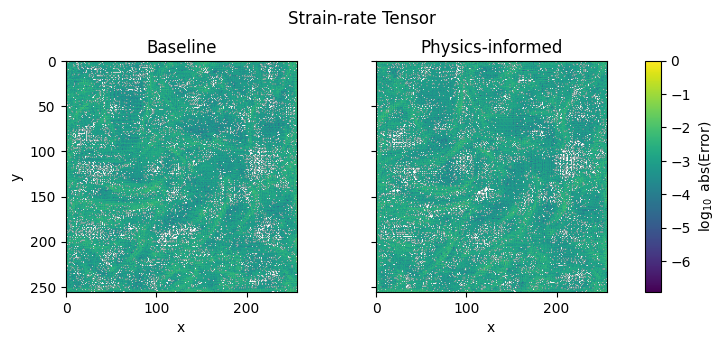

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

axs[0].imshow(np.log10(np.abs(btrue_sym_E - bpred_sym_E)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Baseline')

cmap = axs[1].imshow(np.log10(np.abs(btrue_sym_E - ppred_sym_E)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Physics-informed')

for j in range(2):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')

axs[0].set_ylabel('y')

fig.suptitle('Strain-rate Tensor', y=1.05)
fig.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Error)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/error_sym_E.pdf', bbox_inches='tight')

In [ ]:
# strain-velocity consistency

base_true_Exy_v = 0.5 * (btrue_dvx_dy + btrue_dvy_dx)
base_true_mismatch_Exy = base_true_Exy - base_true_Exy_v
base_true_mismatch_Eyx = base_true_Eyx - base_true_Exy_v

base_pred_Exy_v = 0.5 * (bpred_dvx_dy + bpred_dvy_dx)
base_pred_mismatch_Exy = base_pred_Exy - base_pred_Exy_v
base_pred_mismatch_Eyx = base_pred_Eyx - base_pred_Exy_v

physics_pred_Exy_v = 0.5 * (ppred_dvx_dy + ppred_dvy_dx)
physics_pred_mismatch_Exy = physics_pred_Exy - physics_pred_Exy_v
physics_pred_mismatch_Eyx = physics_pred_Eyx - physics_pred_Exy_v

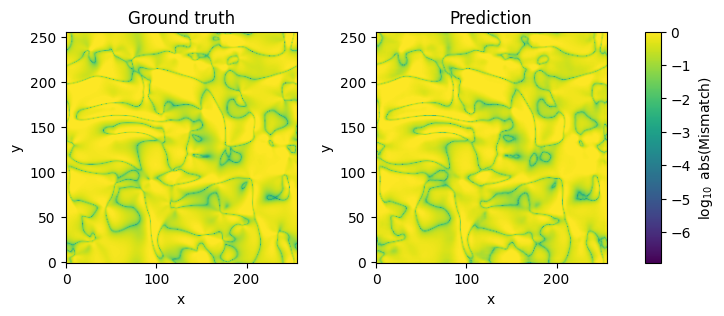

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].imshow(np.log10(np.abs(base_true_mismatch_Exy)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Ground truth')

cmap = axs[1].imshow(np.log10(np.abs(base_pred_mismatch_Exy)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Prediction')

for j in range(2):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')
  axs[j].set_ylabel('y')

fig.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Mismatch)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/Strain_mismatch_baseline_Exy.pdf', bbox_inches='tight')

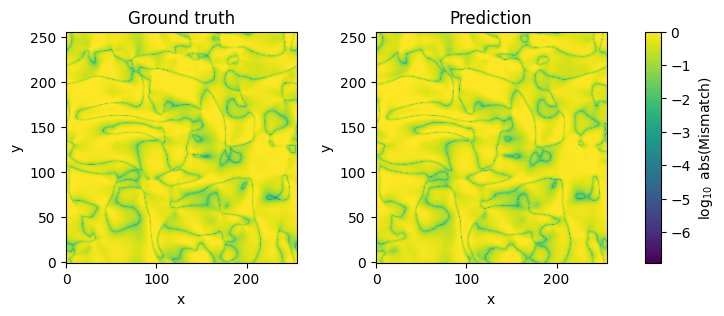

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].imshow(np.log10(np.abs(base_true_mismatch_Exy)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Ground truth')

cmap = axs[1].imshow(np.log10(np.abs(physics_pred_mismatch_Exy)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Prediction')

for j in range(2):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')
  axs[j].set_ylabel('y')

fig.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Mismatch)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/Strain_mismatch_physics_Exy.pdf', bbox_inches='tight')

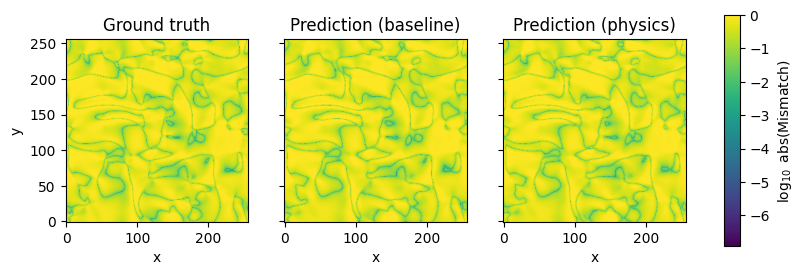

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

axs[0].imshow(np.log10(np.abs(base_true_mismatch_Exy)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Ground truth')

cmap = axs[1].imshow(np.log10(np.abs(base_pred_mismatch_Exy)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Prediction (baseline)')

cmap = axs[2].imshow(np.log10(np.abs(physics_pred_mismatch_Exy)), vmin=-6.923689898635007, vmax=0)
axs[2].set_title('Prediction (physics)')

for j in range(3):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')

axs[0].set_ylabel('y')

fig.subplots_adjust(wspace=0.2, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Mismatch)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/Strain_mismatch_Exy.pdf', bbox_inches='tight')

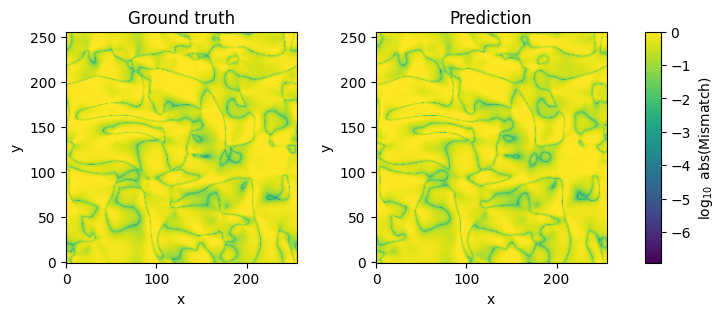

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].imshow(np.log10(np.abs(base_true_mismatch_Eyx)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Ground truth')

cmap = axs[1].imshow(np.log10(np.abs(base_pred_mismatch_Eyx)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Prediction')

for j in range(2):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')
  axs[j].set_ylabel('y')

fig.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Mismatch)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/Strain_mismatch_baseline_Eyx.pdf', bbox_inches='tight')

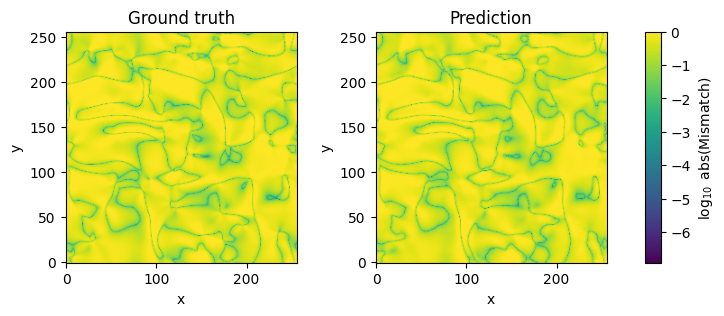

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].imshow(np.log10(np.abs(base_true_mismatch_Eyx)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Ground truth')

cmap = axs[1].imshow(np.log10(np.abs(physics_pred_mismatch_Eyx)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Prediction')

for j in range(2):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')
  axs[j].set_ylabel('y')

fig.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Mismatch)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/Strain_mismatch_physics_Eyx.pdf', bbox_inches='tight')

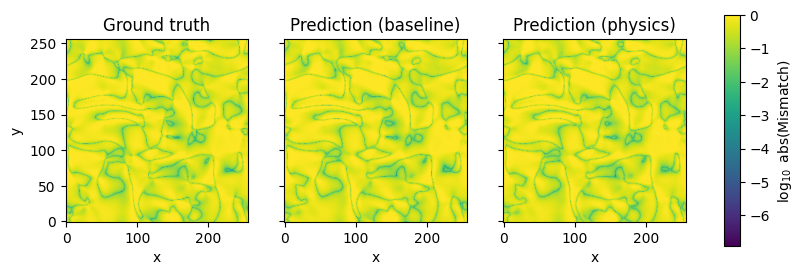

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

axs[0].imshow(np.log10(np.abs(base_true_mismatch_Eyx)), vmin=-6.923689898635007, vmax=0)
axs[0].set_title('Ground truth')

cmap = axs[1].imshow(np.log10(np.abs(base_pred_mismatch_Eyx)), vmin=-6.923689898635007, vmax=0)
axs[1].set_title('Prediction (baseline)')

cmap = axs[2].imshow(np.log10(np.abs(physics_pred_mismatch_Eyx)), vmin=-6.923689898635007, vmax=0)
axs[2].set_title('Prediction (physics)')

for j in range(3):
  axs[j].invert_yaxis()
  axs[j].set_xlabel('x')

axs[0].set_ylabel('y')

fig.subplots_adjust(wspace=0.2, hspace=0)
plt.colorbar(cmap, ax=axs.ravel().tolist(), aspect=15, label=r'$\log_{10}$ abs(Mismatch)', pad=0.05)
plt.savefig('/content/drive/MyDrive/yt/Strain_mismatch_Eyx.pdf', bbox_inches='tight')